In [1]:
from pathlib import Path
import json
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from parse_gam.utils import (
    deduplicate_gdf,
    to_polygon,
    parse_yolo_predictions,
    project_onto_board,
)
from parse_gam.scripts.visualize_state import visualize_state

In [2]:
root_dir = Path(".").resolve().parent / "inference" / "vid1_dataset7_7"
labels_dir = root_dir / "labels"
states_dir = root_dir / "states"
smooth_dir = root_dir / "smooth_states"

In [3]:
sstates_df = pd.DataFrame(
    [json.load(x.open()) for x in smooth_dir.glob("*.json")]
).sort_values(by="file_index")


sstates_df.head()

,Point_1,Point_2,Point_3,Point_4,Point_5,Point_6,Point_7,Point_8,Point_9,Point_10,...,Point_19,Point_20,Point_21,Point_22,Point_23,Point_24,board_1_dice,board_2_dice,status,file_index
42,-2,0,0,0,0,5,0,3,0,0,...,-5,0,0,0,0,2,0.0,0.0,VALID,1
7,-2,0,0,0,0,5,0,3,0,0,...,-5,0,0,0,0,2,0.0,0.0,VALID,2
51,-2,0,0,0,0,5,0,3,0,0,...,-5,0,0,0,0,2,0.0,0.0,VALID,3
18,-2,0,0,0,0,5,0,3,0,0,...,-5,0,0,0,0,2,0.0,0.0,VALID,4
64,-2,0,0,0,0,5,0,3,0,0,...,-5,0,0,0,0,2,0.0,0.0,VALID,5


<Axes: xlabel='file_index'>

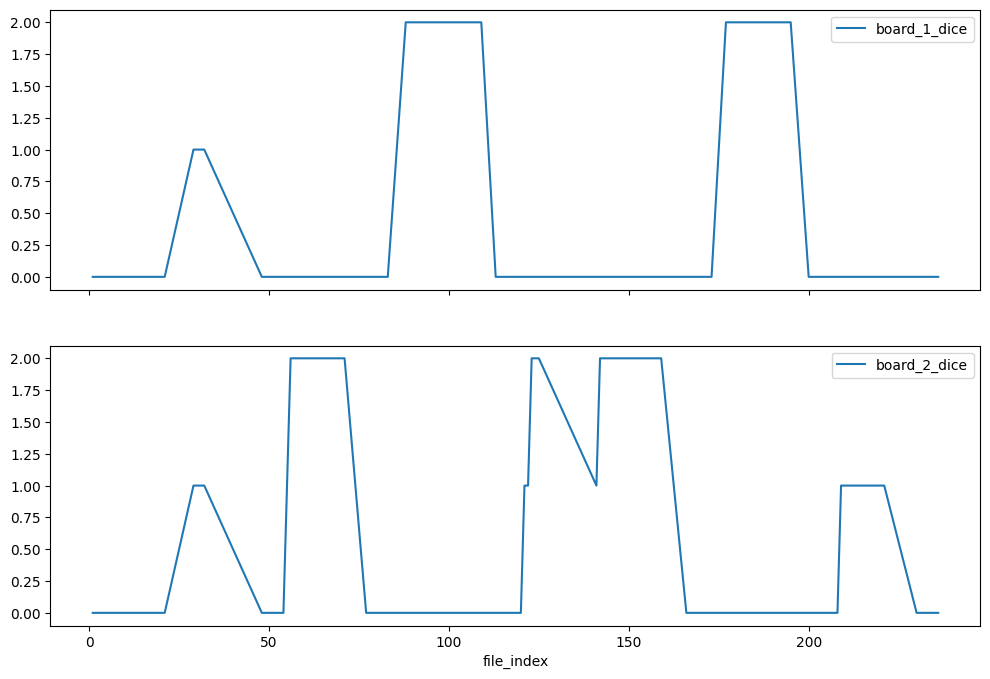

In [8]:
f, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

sstates_df.plot(x="file_index", y="board_1_dice", ax=ax[0])
sstates_df.plot(x="file_index", y="board_2_dice", ax=ax[1])

In [18]:
start_frames = sstates_df[
    (sstates_df.board_1_dice == 1.0) & (sstates_df.board_2_dice == 1.0)
]
game_start_file_index = start_frames.sort_values(by="file_index").iloc[0].file_index
print(f"Game starts at file index:\t{game_start_file_index}")

Game starts at file index:	29


In [ ]:
sstates_df[]

In [49]:
def get_move_start_frames(df, col):
    df = sstates_df.reset_index(drop=True)

    move_starts = []
    in_move = False
    for idx, row in df.iterrows():
        dice = row[col]
        if not in_move and dice == 2:
            move_starts.append(row["file_index"])
            in_move = True
        elif in_move and dice == 0:
            in_move = False
    return move_starts


p1_move_starts = get_move_start_frames(sstates_df, "board_2_dice")
p2_move_starts = get_move_start_frames(sstates_df, "board_1_dice")
all_move_starts = sorted([*p1_move_starts, *p2_move_starts])
point_cols = [f"Point_{x}" for x in range(1, 25)]

In [48]:
print(p1_move_starts)
print(p2_move_starts)
print(all_move_starts)

[56, 123]
[88, 177]
[56, 88, 123, 177]


In [40]:
# sstates_df[(sstates_df.file_index > 29) & (sstates_df.file_index < 56)].

s1 = sstates_df[sstates_df.file_index == 29][point_cols]
s2 = sstates_df[sstates_df.file_index == 55][point_cols]

In [50]:
(s2.iloc[0] - s1.iloc[0]).to_dict()

{'Point_1': 0,
 'Point_2': 0,
 'Point_3': 0,
 'Point_4': 0,
 'Point_5': 0,
 'Point_6': 0,
 'Point_7': 0,
 'Point_8': 0,
 'Point_9': 0,
 'Point_10': 0,
 'Point_11': 0,
 'Point_12': 0,
 'Point_13': 0,
 'Point_14': 0,
 'Point_15': 0,
 'Point_16': 0,
 'Point_17': 1,
 'Point_18': 0,
 'Point_19': 1,
 'Point_20': -2,
 'Point_21': 0,
 'Point_22': 0,
 'Point_23': 0,
 'Point_24': 0}

In [52]:
all_moves = []
for move_idx in range(len(all_move_starts)):
    s_idx = all_move_starts[move_idx - 1] if move_idx != 0 else game_start_file_index
    end_idx = all_move_starts[move_idx]

    move_start_state = sstates_df[sstates_df.file_index == s_idx][point_cols]
    move_end_state = sstates_df[sstates_df.file_index == end_idx][point_cols]

    move = (move_end_state.iloc[0] - move_start_state.iloc[0]).to_dict()
    all_moves.append(move)

moves_df = pd.DataFrame(all_moves)
moves_df.head()

,Point_1,Point_2,Point_3,Point_4,Point_5,Point_6,Point_7,Point_8,Point_9,Point_10,...,Point_15,Point_16,Point_17,Point_18,Point_19,Point_20,Point_21,Point_22,Point_23,Point_24
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,-2,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,-1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,-3,0,0
3,0,0,0,0,0,0,0,1,0,-1,...,0,0,0,0,0,0,1,0,0,0


In [61]:
moves_df.reset_index(names="move_index")

,move_index,Point_1,Point_2,Point_3,Point_4,Point_5,Point_6,Point_7,Point_8,Point_9,...,Point_15,Point_16,Point_17,Point_18,Point_19,Point_20,Point_21,Point_22,Point_23,Point_24
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,-2,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,-1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,-3,0,0
3,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
